In [1]:
import sys
import numpy as np
from sklearn.model_selection import train_test_split
from keras import mixed_precision
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    concatenate,
    BatchNormalization,
)

2024-08-01 15:11:05.964015: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 15:11:05.964040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 15:11:05.965241: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-01 15:11:05.970098: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Enable mixed precision
mixed_precision.set_global_policy("mixed_float16")

In [3]:
sys.path.append("../helpers")
from audio_process import AudioProcess
from ProjectData import ProjectData
from audio_visualization import show_mfcc_from_json, show_melspectrogram_from_json

In [4]:
sys.path.append("../helpers")
from ProjectData import ProjectData
from model_pipeline import DataGenerator, plot_history

prd = ProjectData()

In [5]:
data = prd.get_data_paths()["melSpectrogram_mfcc"]
map_labels = {i: key for i, key in enumerate(prd.get_audio_paths())}
num_classes = len(map_labels)

In [6]:
X = []
y = []
for item in data:
    key, path = list(item.items())[0]
    X.append(path)
    y.append(key)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, shuffle=True
)

In [8]:
batch_size = 16
input_shape_mel = (128, 1293, 1)
input_shape_mfccs = (13, 1293, 1)

In [9]:
train_generator = DataGenerator(
    X_train,
    y_train,
    input_shape_mel,
    input_shape_mfccs,
    num_classes=num_classes,
    batch_size=batch_size,
)
val_generator = DataGenerator(
    X_val,
    y_val,
    input_shape_mel,
    input_shape_mfccs,
    num_classes=num_classes,
    batch_size=batch_size,
)
test_generator = DataGenerator(
    X_test,
    y_test,
    input_shape_mel,
    input_shape_mfccs,
    num_classes=num_classes,
    batch_size=batch_size,
)

In [10]:
def create_model(input_shape_mel, input_shape_mfccs, num_classes):
    # Mel spectrogram branch
    input_mel = Input(shape=input_shape_mel, name="input_mel")
    x_mel = Conv2D(32, (3, 3), activation="relu", padding="same")(input_mel)
    x_mel = BatchNormalization()(x_mel)
    x_mel = MaxPooling2D((2, 2))(x_mel)
    x_mel = Conv2D(64, (3, 3), activation="relu", padding="same")(x_mel)
    x_mel = BatchNormalization()(x_mel)
    x_mel = MaxPooling2D((2, 2))(x_mel)
    x_mel = Conv2D(128, (3, 3), activation="relu", padding="same")(x_mel)
    x_mel = BatchNormalization()(x_mel)
    x_mel = MaxPooling2D((2, 2))(x_mel)
    x_mel = Flatten()(x_mel)

    # MFCC branch
    input_mfccs = Input(shape=input_shape_mfccs, name="input_mfccs")
    x_mfccs = Conv2D(32, (3, 3), activation="relu", padding="same")(input_mfccs)
    x_mfccs = BatchNormalization()(x_mfccs)
    x_mfccs = MaxPooling2D((2, 2))(x_mfccs)
    x_mfccs = Conv2D(64, (3, 3), activation="relu", padding="same")(x_mfccs)
    x_mfccs = BatchNormalization()(x_mfccs)
    x_mfccs = MaxPooling2D((2, 2))(x_mfccs)
    x_mfccs = Conv2D(128, (3, 3), activation="relu", padding="same")(x_mfccs)
    x_mfccs = BatchNormalization()(x_mfccs)
    x_mfccs = MaxPooling2D((2, 2))(x_mfccs)
    x_mfccs = Flatten()(x_mfccs)

    # Concatenate the outputs of both branches
    concatenated = concatenate([x_mel, x_mfccs])

    # Fully connected layers
    x = Dense(256, activation="relu")(concatenated)
    x = BatchNormalization()(x)
    x = Dropout(0.7)(x)
    x = Dense(128, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.55)(x)
    output = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=[input_mel, input_mfccs], outputs=output)
    return model

In [11]:
model = create_model(input_shape_mel, input_shape_mfccs, num_classes)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

2024-08-01 15:11:07.892863: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-01 15:11:07.937111: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-01 15:11:07.937305: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_mel           │ (None, 128, 1293, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_mfccs         │ (None, 13, 1293,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 1293, │        320 │ input_mel[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 13, 1293,  │        320 │ input_mfccs[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 1293, │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 1293,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 646,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 646,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 646,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 6, 646,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 646,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 646,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 323,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 3, 323,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 323,   │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 3, 323,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 323,   │        512 │ conv2d_2[0][0]  

 Total params: 89,909,130 (342.98 MB)

 Trainable params: 89,907,466 (342.97 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [13]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

In [14]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # Adjust the number of epochs as needed
    callbacks=[early_stopping],
)

Epoch 1/50


/home/maxen/miniforge3/envs/MusicGenre/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1722517883.803151  249512 service.cc:145] XLA service 0x55d7245a6ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722517883.803182  249512 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2024-08-01 15:11:23.949101: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-01 15:11:25.309201: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 890

  2/239 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.0625 - loss: 4.0093   

I0000 00:00:1722517911.519641  249512 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


238/239 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1637 - loss: 3.1315

2024-08-01 15:17:17.503031: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 358744064 exceeds 10% of free system memory.
2024-08-01 15:17:18.100917: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 358744064 exceeds 10% of free system memory.


239/239 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step - accuracy: 0.1642 - loss: 3.1286 - val_accuracy: 0.1070 - val_loss: 12.7898
Epoch 2/50
238/239 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3067 - loss: 2.1901

2024-08-01 15:22:54.256466: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 358744064 exceeds 10% of free system memory.


239/239 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.3069 - loss: 2.1891 - val_accuracy: 0.4184 - val_loss: 1.7425
Epoch 3/50
238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - accuracy: 0.4041 - loss: 1.7645

2024-08-01 15:27:53.540429: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 358744064 exceeds 10% of free system memory.


239/239 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.4043 - loss: 1.7638 - val_accuracy: 0.5646 - val_loss: 1.2388
Epoch 4/50
238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - accuracy: 0.5028 - loss: 1.3999

2024-08-01 15:32:52.899229: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 358744064 exceeds 10% of free system memory.


239/239 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.5031 - loss: 1.3992 - val_accuracy: 0.6483 - val_loss: 1.0573
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.5896 - loss: 1.1535 - val_accuracy: 0.5943 - val_loss: 1.1489
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - accuracy: 0.6949 - loss: 0.9264 - val_accuracy: 0.6557 - val_loss: 0.9516
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.7888 - loss: 0.6681 - val_accuracy: 0.8581 - val_loss: 0.4746
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accuracy: 0.8316 - loss: 0.5257 - val_accuracy: 0.7797 - val_loss: 0.6106
Epoch 9/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.8782 - loss: 0.3956 - val_accuracy: 0.8919 - val_loss: 0.3872
Epoch 10/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.9084 - loss: 0.3066 - val_accuracy: 0.8761 - val_loss: 0.3679
Epoch 11/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.9162 - loss: 0.2698 - val_accuracy: 0.8

In [15]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

74/74 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9903 - loss: 0.0544
Test Loss: 0.08723169565200806
Test Accuracy: 0.9805743098258972


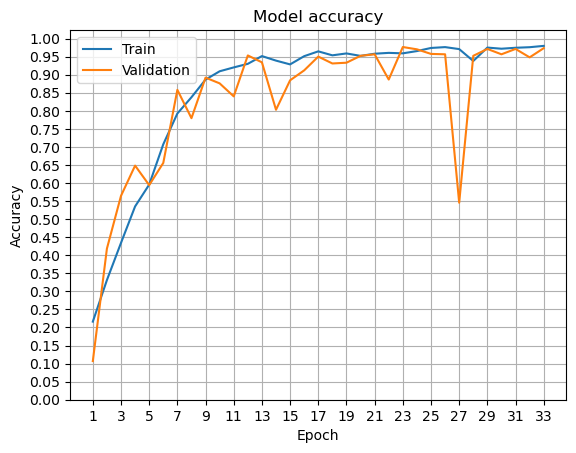

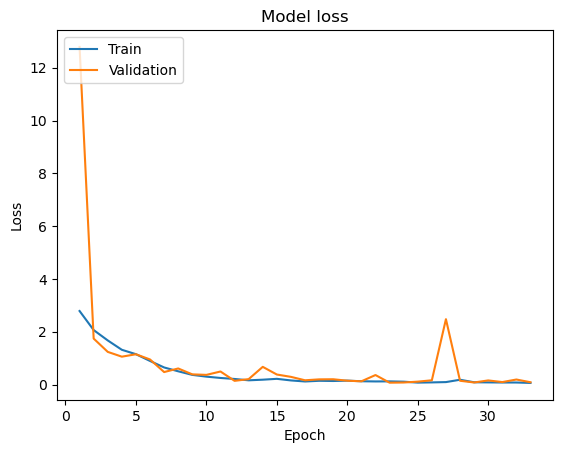

In [16]:
plot_history(history, step=2)